<a href="https://colab.research.google.com/github/sayakpaul/TF-2.0-Hacks/blob/master/Benchmarking_TRT_TFLite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I am going to present some useful ways to optimize deep learning inference using [TensorRT](https://developer.nvidia.com/tensorrt) and [TensorFlow Lite](https://www.tensorflow.org/lite/). Note that for TensorRT to show its magic, you would need a supported GPU device. 

In [1]:
!nvidia-smi

Wed Feb 12 08:27:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0


In [0]:
!mkdir mobilenet_v2

We will be using a pretrained MobileNetV2 model but you can try out other ones too. 

In [4]:
# We are going to save the model in TensorFlow Saved Model format
mobilenet_v2 = tf.keras.applications.MobileNetV2(weights='imagenet')
mobilenet_v2.save('mobilenet_v2')

14540800/14536120 [==============================] - 1s 0us/step
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: mobilenet_v2/assets


In [5]:
# Size of the model files
!ls -lh mobilenet_v2

total 4.0M
drwxr-xr-x 2 root root 4.0K Feb 12 08:28 assets
-rw-r--r-- 1 root root 4.0M Feb 12 08:28 saved_model.pb
drwxr-xr-x 2 root root 4.0K Feb 12 08:28 variables


In [0]:
# Gather sample data
!wget -O elephant.jpg https://sm.mashable.com/t/mashable_sea/fun/i/indias-fir/indias-first-elephant-hospital-has-opened-and-people-are-rej_45f1.960.jpg

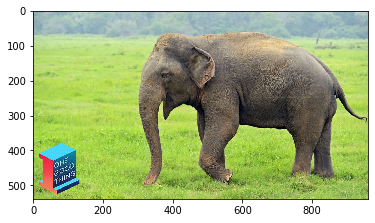

In [7]:
import matplotlib.pyplot as plt

sample_image = plt.imread('elephant.jpg')
plt.imshow(sample_image)
plt.show()

In [8]:
# Perform prediction in a Keras native way
# Referred from http://keras.io/applications/
import numpy as np

# Prepare the image for prediction
img = tf.keras.preprocessing.image.load_img('elephant.jpg', target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

# Run inference
preds = mobilenet_v2.predict(x)
print('Predicted:', tf.keras.applications.mobilenet_v2.decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02504013', 'Indian_elephant', 0.70024925), ('n01871265', 'tusker', 0.2549572), ('n02504458', 'African_elephant', 0.0033761878)]


In [0]:
# Let's see the timing
# Courtesy: https://www.dlology.com/blog/how-to-run-keras-model-on-jetson-nano/
import time

def time_my_model(model, data):
    times = []
    for i in range(20):
        start_time = time.time()
        one_prediction = model.predict(data)
        delta = (time.time() - start_time)
        times.append(delta)
    mean_delta = np.array(times).mean()
    fps = 1 / mean_delta
    print('average(sec):{:.2f},fps:{:.2f}'.format(mean_delta, fps))

In [10]:
time_my_model(mobilenet_v2, x)
time_my_model(mobilenet_v2, x)
time_my_model(mobilenet_v2, x)
time_my_model(mobilenet_v2, x)
time_my_model(mobilenet_v2, x)

average(sec):0.03,fps:37.22
average(sec):0.03,fps:36.54
average(sec):0.03,fps:36.54
average(sec):0.03,fps:38.93
average(sec):0.03,fps:37.24


Let's see how can we optimize this model using TensorRT. I recommend reading about the TensorFlow TRT integration from [this article](https://blog.tensorflow.org/2018/04/speed-up-tensorflow-inference-on-gpus-tensorRT.html) as it is amazingly outlined and has touched base on really important concepts and API designs. 

In [0]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt

In [12]:
# Convert the SavedModel using TF-TRT

# Prepare the configuration params for the conversion
params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
    precision_mode='FP16',
    is_dynamic_op=True)

# Perform conversion
converter = trt.TrtGraphConverterV2(
    input_saved_model_dir='mobilenet_v2',
    conversion_params=params)
converter.convert()

# Serialize the optimized graph
saved_model_dir_trt = 'mobilenet_v2.trt'
converter.save(saved_model_dir_trt)

INFO:tensorflow:Linked TensorRT version: (0, 0, 0)
INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)
INFO:tensorflow:Assets written to: mobilenet_v2.trt/assets


In [13]:
# Size of the model
!ls -lh mobilenet_v2.trt

total 31M
drwxr-xr-x 2 root root 4.0K Feb 12 08:30 assets
-rw-r--r-- 1 root root  31M Feb 12 08:30 saved_model.pb
drwxr-xr-x 2 root root 4.0K Feb 12 08:30 variables


In [0]:
# Load the particular signature from the TRT graph
root = tf.saved_model.load(saved_model_dir_trt)
concrete_func = root.signatures['serving_default']

In [0]:
# Needs to be run at least two times as warm up
# The function is referred from a GitHub gist but I am unable to recollect the exact link
def time_trt_model():
    image_input = tf.constant(x.astype('float32'))
    times = []
    for i in range(20):
        start_time = time.time()
        one_prediction = concrete_func(input_1=image_input)
        delta = (time.time() - start_time)
        times.append(delta)
    mean_delta = np.array(times).mean()
    fps = 1 / mean_delta
    print('average(sec):{:.2f},fps:{:.2f}'.format(mean_delta, fps))

In [16]:
time_trt_model()
time_trt_model()
time_trt_model()
time_trt_model()
time_trt_model()

average(sec):0.03,fps:29.46
average(sec):0.00,fps:327.01
average(sec):0.00,fps:328.45
average(sec):0.00,fps:317.29
average(sec):0.00,fps:288.89


The speed-up is huge. 

You can use `mobilenet_v2.trt` to load the TRT variant of the model and make predictions like so:

In [17]:
# Gather the ImageNet labels first and prepare them
labels_path = tf.keras.utils.get_file(
    'ImageNetLabels.txt',
    'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


In [18]:
# Load the TRT graph and inspect the shapes
loaded = tf.saved_model.load('mobilenet_v2.trt')
infer = loaded.signatures['serving_default']
print(infer.structured_outputs)

{'Logits': TensorSpec(shape=(None, 1000), dtype=tf.float32, name='Logits')}


Notice that the final layer of the graph is left with logits, it does not contain any activation function to squish the logits to probabilities. 

In [19]:
# Perform inference
labeling = infer(tf.constant(x.astype('float32')))
activations = tf.nn.softmax(labeling["Logits"])
imagenet_labels[np.argsort(activations)[0,::-1][:5]+1]

array(['Indian elephant', 'tusker', 'African elephant', 'bull mastiff',
       'Great Dane'], dtype='<U30')

Let's now try out TFLite's performance. The following block of code is attributed to: https://www.tensorflow.org/lite/convert/python_api.

In [20]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(mobilenet_v2)
tflite_model = converter.convert()

# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the TensorFlow Lite model on random input data
input_shape = input_details[0]['shape']
interpreter.set_tensor(input_details[0]['index'], x.astype('float32'))
interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data
# Use `tensor()` in order to get a pointer to the tensor
tflite_results = interpreter.get_tensor(output_details[0]['index'])

# Parse the results
imagenet_labels[np.argsort(tflite_results)[0,::-1][:5]+1]

array(['Indian elephant', 'tusker', 'African elephant', 'bull mastiff',
       'Great Dane'], dtype='<U30')

Let's now benchmark it. 

In [0]:
def time_tflite_model():
    times = []
    for i in range(20):
        start_time = time.time()
        interpreter.invoke()
        delta = (time.time() - start_time)
        times.append(delta)
    mean_delta = np.array(times).mean()
    fps = 1 / mean_delta
    print('average(sec):{:.2f},fps:{:.2f}'.format(mean_delta, fps))

In [22]:
time_tflite_model()
time_tflite_model()
time_tflite_model()
time_tflite_model()
time_tflite_model()

average(sec):0.02,fps:41.76
average(sec):0.02,fps:41.33
average(sec):0.02,fps:42.96
average(sec):0.02,fps:43.08
average(sec):0.02,fps:42.21


I think the main reason TensorRT is giving such good results is because it is able to take advantage of the available GPU cores. 

In [26]:
# Serialize the TFLite model and see it's size
!mkdir tflite_model

f = open("tflite_model/mobilenet_v2.tflite", "wb")
f.write(tflite_model)
f.close()

!ls -lh tflite_model

total 14M
-rw-r--r-- 1 root root 14M Feb 12 08:35 mobilenet_v2.tflite
